In [126]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

%matplotlib inline

# we load the FashionMNIST dataset
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

def img2vec(img):
    return torch.flatten(img, start_dim=1)

def vec2img(vec):
    return torch.reshape(vec, (-1, 1, 28, 28))

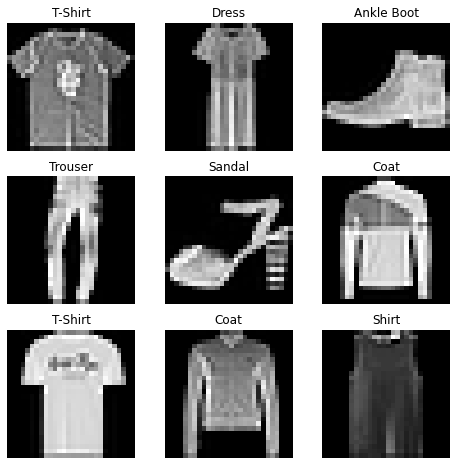

In [127]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Define model

In [128]:
from torch.nn import Module, Linear

class Encoder(Module):
    def __init__(self, d, n1, lat):
        super(Encoder, self).__init__()
        self.l1 = Linear(d, n1)
        self.mean = Linear(n1, lat)
        self.std = Linear(n1, lat)
        
    def forward(self, x):
        x = torch.relu(self.l1(x))
        mu = self.mean(x)
        sigma = torch.exp(self.std(x))

        return mu, sigma

class Decoder(Module):
    def __init__(self, d, n1, lat):
        super(Decoder, self).__init__()
        self.l1 = Linear(lat, n1)
        self.l2 = Linear(n1, d)

    def forward(self, z):
        z = torch.relu(self.l1(z))
        z = torch.sigmoid(self.l2(z))
        return z

class VAE(Module):
    def __init__(self, d, n1, lat):
        super(VAE, self).__init__()
        self.encoder = Encoder(d, n1, lat)
        self.decoder = Decoder(d, n1, lat)
        self.img_loss = torch.tensor(0)

    def reconstruct_loss(self, x, y):
        return torch.sum((x - y) ** 2) # for the continuous gaussian density
    
    def kl_loss(self, mu, sigma):
        return torch.sum(mu ** 2 + sigma ** 2 - torch.log(sigma) - 0.5)
    
    def gaussian(self, mu, sigma):
        return mu + sigma * torch.normal(torch.zeros(mu.shape), torch.ones(mu.shape))
        
    def forward(self, x):
        mu, sigma = self.encoder(x)
        z = self.gaussian(mu, sigma)
        y = self.decoder(z)

        self.img_loss = self.reconstruct_loss(x, y) + self.kl_loss(mu, sigma)

        return y
    
    def batch_loss(self):
        return torch.sum(self.img_loss)

    def backward(self):
        self.img_loss.backward()

Define training loop

In [129]:
from torch.optim import Adam

d = 28 * 28
n1 = 256
lat = 128
epochs = 20
batch_size = 128

training_data = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_data = DataLoader(test_data, batch_size=batch_size, shuffle=True)

batches = len(training_data)

vae = VAE(d, n1, lat)
adam = Adam(vae.parameters())

for e in range(epochs):
    loss = 0
    for x_batch, _ in training_data:
        x_batch = img2vec(x_batch)
        adam.zero_grad()
        vae.forward(x_batch)

        loss += vae.batch_loss()
        vae.backward()
        adam.step()

    print(f"Training loss [{e + 1}/{epochs}]: {loss / batches / batch_size:0.4f}")

Training loss [1/20]: 92.3955
Training loss [2/20]: 80.5035
Training loss [3/20]: 76.4314
Training loss [4/20]: 74.2016
Training loss [5/20]: 72.7928
Training loss [6/20]: 71.8114
Training loss [7/20]: 71.1678
Training loss [8/20]: 70.7143
Training loss [9/20]: 70.4061
Training loss [10/20]: 70.1673
Training loss [11/20]: 70.0015
Training loss [12/20]: 69.8267
Training loss [13/20]: 69.7205
Training loss [14/20]: 69.5906
Training loss [15/20]: 69.4910
Training loss [16/20]: 69.3909
Training loss [17/20]: 69.3180
Training loss [18/20]: 69.2738
Training loss [19/20]: 69.1941
Training loss [20/20]: 69.1442


In [130]:
total_loss = 0
batches = len(test_data)

for x_batch, _ in test_data:
    x_batch = img2vec(x_batch)
    vae.forward(x_batch)

    total_loss += vae.batch_loss()

print(f"Test loss: {total_loss / batches / batch_size:0.4f}")

Test loss: 68.4457


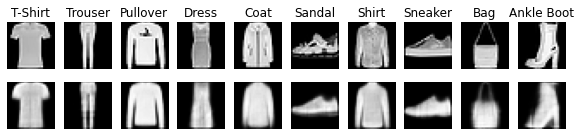

In [131]:
imgs = {}
for test_batch, label_batch in test_data:
    for idx in range(batches):
        img = test_batch[idx]
        label = label_batch[idx].item()

        if label not in imgs:
            imgs[label] = img
        
        if len(imgs) == 10:
            break

    if len(imgs) == 10:
        break

figure = plt.figure(figsize=(10, 2))
cols, rows = 10, 2
label = 0
for i in range(1, int(cols * rows / 2) + 1):
    img = imgs[label]

    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")

    label += 1

label = 0
for i in range(int(cols * rows / 2) + 1, cols * rows + 1):
    img = imgs[label]
    img = vec2img(vae.forward(img2vec(img)))

    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.detach().squeeze(), cmap="gray")

    label += 1

plt.show()